In [24]:
from rsi_duckdb import *

if __name__ == "__main__":
    
    #datapath = os.path.join(modpath, 'orcl-1995-2014.txt')
    datapath = os.path.join('../../datacron/yahoo-finance/localstore/daily/2000-01-01_0.parquet')
    df = db.sql(f"""
        select * from read_parquet("{datapath}")
    """).df()
    rsi = addrsi(df,14)
    sig = addrsi_signal(rsi)
    cba = db.sql(f"""
        select Close, rsi_{14}, buy_sig*100, sell_sig*100
        , EMA(Close, 0.2) 
       OVER (ORDER BY date ROWS BETWEEN 4 PRECEDING AND CURRENT ROW) 
       AS ema
        from sig
        where Ticker = 'CBA.AX'
        and Date > '2024-01-01'
        order by Date 
    """).df()
    cba.plot()
    plt.show()

CatalogException: Catalog Error: Aggregate Function with name ema does not exist!
Did you mean "mean"?

In [2]:
import pandas as pd
df = pd.read_csv("../../datacron/yahoo-finance/ASX_Listed_Companies_30-01-2025_02-54-26_AEDT.csv")
# print(df)
df['Market Cap'] = df['Market Cap'].apply(lambda v: None if v in ("SUSPENDED", "--") else int(v))
dfvalid = df.sort_values(by="Market Cap", ascending=False)[~df["Market Cap"].isna()]

/tmp/ipykernel_16449/2461206533.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dfvalid = df.sort_values(by="Market Cap", ascending=False)[~df["Market Cap"].isna()]


In [3]:
dfvalid1 = db.sql("""
    select *, rank() over (order by "Market Cap" desc) as market_rank
    from dfvalid                  
""")
dfvalid1

┌──────────┬──────────────────────────────────┬────────────────────────────────────────────────┬──────────────┬────────────────┬─────────────┐
│ ASX code │           Company name           │              GICs industry group               │ Listing date │   Market Cap   │ market_rank │
│ varchar  │             varchar              │                    varchar                     │   varchar    │     double     │    int64    │
├──────────┼──────────────────────────────────┼────────────────────────────────────────────────┼──────────────┼────────────────┼─────────────┤
│ CBA      │ COMMONWEALTH BANK OF AUSTRALIA.  │ Banks                                          │ 12/09/1991   │ 266549084382.0 │           1 │
│ BHP      │ BHP GROUP LIMITED                │ Materials                                      │ 13/08/1885   │ 200317618902.0 │           2 │
│ CSL      │ CSL LIMITED                      │ Pharmaceuticals, Biotechnology & Life Sciences │ 08/06/1994   │ 131936645976.0 │           3 │

Index(['Close', 'rsi_14', 'Ticker', 'Date'], dtype='object')


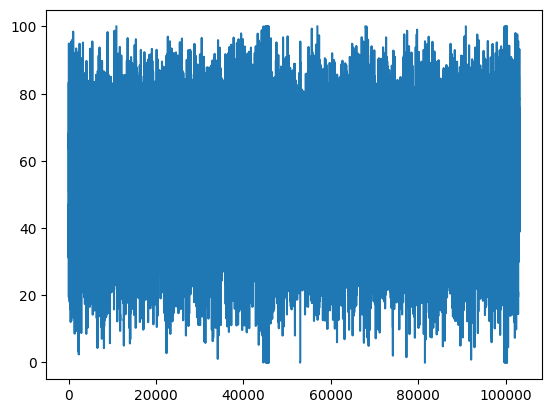

In [22]:
subset = db.sql("""
    select Close, rsi_14, Ticker, Date
    from sig s
    inner join dfvalid1 v on
        concat(trim(v."ASX Code"), '.AX') = s."Ticker"
    where year(s.Date) > 2010
        and v.market_rank <= 32
        --and Ticker = 'NAB.AX'
""").df()
print(subset.columns)
subset['rsi_14'].plot()
import plotly.express as px
subset['Date'] = pd.to_datetime(subset['Date'])
subset['rsi_14'] = pd.to_numeric(subset['rsi_14'], errors='coerce')
fig = px.line(subset, x='Date', y='Close',facet_col = 'Ticker' , facet_col_wrap=4, facet_row_spacing = 0.01, width=400,height=800)
fig.update_yaxes(matches=None)
fig.write_image("fig.png")

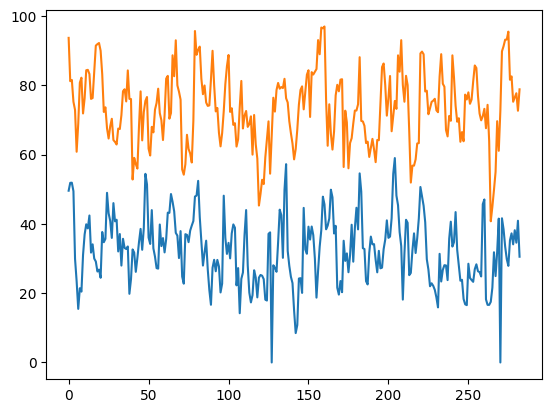

In [15]:
# check the frequency of purchase opportunities
min_rsi = db.sql("""
    with top10 as (
        select Close, rsi_14, Ticker, Date
        from sig s
        inner join dfvalid1 v on
            concat(trim(v."ASX Code"), '.AX') = s."Ticker"
        where year(s.Date) > 2023
            and v.market_rank <= 10
    )
    select 
        min(rsi_14) as rsi_14
        , max(rsi_14) as rsi_14_max
        , Date        
    from top10
    group by Date
""").df()
import plotly.express as px
min_rsi['rsi_14'].plot()
min_rsi['rsi_14_max'].plot()

fig = px.scatter(min_rsi, x='Date', y='rsi_14')
fig.write_image("fig_min_rsi_10.png")

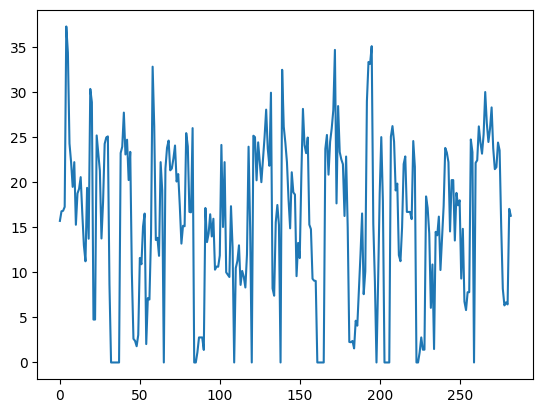

In [13]:
# check the frequency of purchase opportunities
min_rsi = db.sql("""
    with top100 as (
        select Close, rsi_14, Ticker, Date
        from sig s
        inner join dfvalid1 v on
            concat(trim(v."ASX Code"), '.AX') = s."Ticker"
        where year(s.Date) > 2023
            and v.market_rank <= 100
    )
    select min(rsi_14) as rsi_14, Date
    from top100
    group by Date
""").df()
min_rsi['rsi_14'].plot()
import plotly.express as px
fig = px.scatter(min_rsi, x='Date', y='rsi_14')
fig.write_image("fig_min_rsi_100.png")

In [ ]:
(
    db.sql("""
        select count(distinct ticker), count(distinct year(Date)), count(case when year(Date)> 2020 then 1 end)
        from sig s
        inner join dfvalid v on
            v."ASX Code" || '.AX' = s."Ticker"
    """).df(),
)

In [ ]:
sig[['Close','rsi_14']].plot(sharey=False, sharex= False, subplots=True)

In [ ]:
import duckdb as db

frequent_signal_stocks = db.sql("""
    select sum(buy_sig) as total_buy_sig, sum(sell_sig) as total_sell_sig, Ticker
    from sig
    where Date > '2024-01-01'
    group by Ticker
    order by total_buy_sig desc, total_sell_sig desc
""").df().head(10)

In [ ]:
for ticker in frequent_signal_stocks['Ticker']:
    data = db.sql(f"""
        select Close, rsi_{14}, buy_sig*100, sell_sig*100
        from sig
        where Ticker = '{ticker}'
        and Date > '2024-01-01'
        order by Date 
    """).df()
    data.plot( sharey=False, subplots=True)
    plt.show()

In [ ]:
import pandas as pd

# Set options to display all rows and columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 0) # Adjust to your console width if needed

df = db.read_csv("../../datacron/yahoo-finance/ASX_Listed_Companies_30-01-2025_02-54-26_AEDT.csv").df()
    # print(df)
df['Market Cap'] = df['Market Cap'].apply(lambda v: None if v in ("SUSPENDED", "--") else int(v))
df.sort_values("Market Cap", ascending = False).head(200)